In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import multivariate_normal

np.random.seed(0)

### Create a dataset

In [2]:
K=3 # number of sources
d=2 # dimension of the data
    
def create_dataset():
    # Create dataset
    
    X=[]
    mu1=[2,2]
    Sigma1=np.array([[3,-2],[-2,3]])
    Gauss1= multivariate_normal(mean=mu1,cov=Sigma1)
    samples1=Gauss1.rvs(200) # Draw random samples from the multivariate normal distribution.

    mu2=[-8,-4]
    Sigma2=np.array([[4,2],[2,4]])
    Gauss2= multivariate_normal(mean=mu2,cov=Sigma2)
    samples2=Gauss2.rvs(400)

    mu3=[-8,7]
    Sigma3=np.array([[1,0],[0,1]])
    Gauss3= multivariate_normal(mean=mu3,cov=Sigma3)
    samples3=Gauss3.rvs(600)

    X=np.vstack((samples1,samples2,samples3))
    
    np.random.shuffle(X)
    return X


In [3]:
X=create_dataset()
n_samples = len(X)
print(X.shape)

(1200, 2)


Text(0.5, 1.0, 'Dataset')

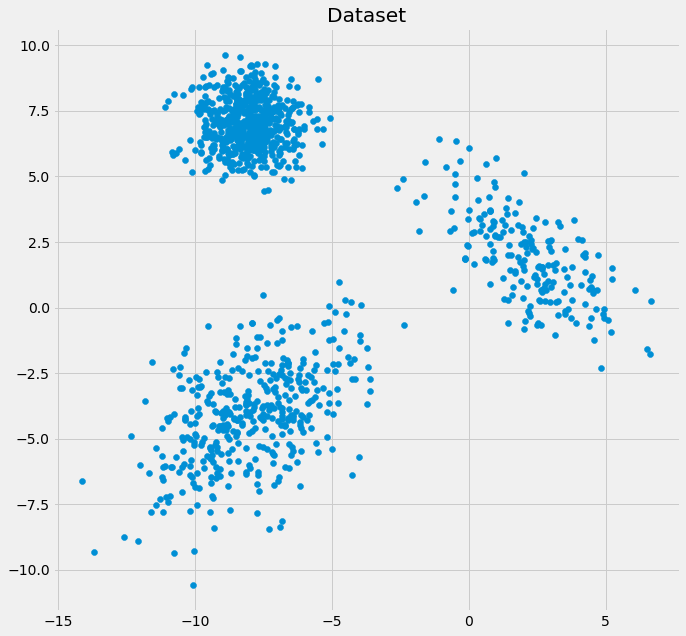

In [4]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1])
ax0.set_title('Dataset')

### Initalize Parameters

In [5]:
 
def init_params(K,d):
    """ Set the initial mu, covariance and pi values"""

    # This is a Kxd matrix since we assume K Gaussians where each has d dimensions
    mu=np.array([[1.0,0.0],[-5.0,2.0],[-2.0,-2.0]])
    #mu = np.random.randint(-4,4,size=(K,d)) 

    print(mu)

    
    # We need a Kxdxd covariance matrix for each Gauss distribution since we have d features 
    #--> We create symmetric covariance matrices with ones on the digonal
    
    cov = np.zeros((K,d,d))
    print(cov.shape)

    for dim in range(len(cov)):
        np.fill_diagonal(cov[dim],2.0)

    print(cov)

    # Set pi to uniform distribution
    pi = np.ones(K)/K 
    print(pi)

    return mu, cov, pi



In [6]:
mu, cov, pi = init_params(K,d)

[[ 1.  0.]
 [-5.  2.]
 [-2. -2.]]
(3, 2, 2)
[[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]
[0.33333333 0.33333333 0.33333333]


In [7]:
def plot_results(X, **kwargs):
    """Plot the dataset"""    
    
    fig = plt.figure(figsize=(10,10))
    ax0 = fig.add_subplot(111)
    ax0.scatter(X[:,0],X[:,1])
    
    try:
      title = kwargs['title']
    except:
      title='results'
    ax0.set_title(title)
    
    try:
        mu = kwargs['mu']
        for m in mu:
            ax0.scatter(m[0],m[1],c='red',zorder=10,s=100)
    except:
        pass
    
    try:
        cov = kwargs ['cov']
        x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
        XY = np.array([x.flatten(),y.flatten()]).T
        reg_cov = 1e-6*np.identity(len(X[0,:]))
        
        for c,m in zip(cov,mu):
            c += reg_cov
            # let us set up the mean and covariance of a multi-dim gaussian
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.3)
    
    except:
        pass
    
    plt.show()
    fig.savefig(title+'.png')

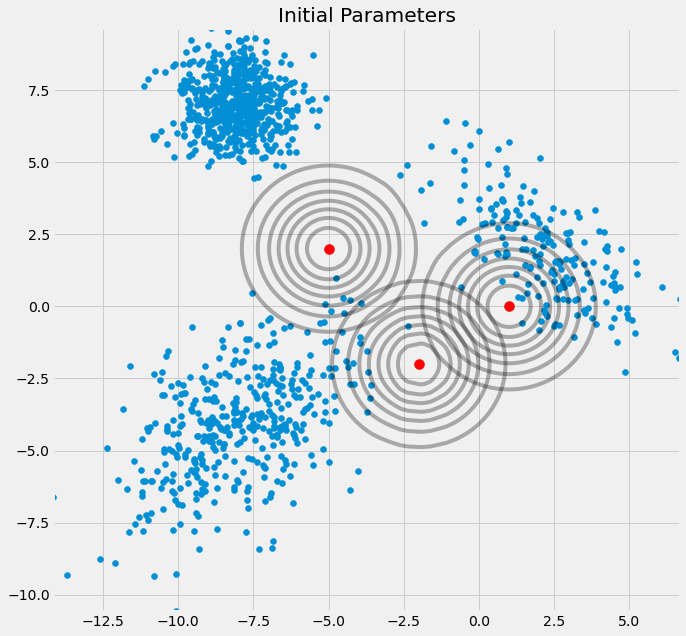

In [8]:
plot_results(X, mu=mu,cov=cov, title='Initial Parameters')

### E Step starts here

In [9]:
reg_cov = 1e-6*np.identity(d)
log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                     # if we have converged

$$R_{i,j}^{t-1}=P(y_j=i|x_j,\theta^{t-1})=\frac{\exp\left\{-\frac{1}{2}(x_j-\mu_i^{t-1})^T(\Sigma_i^{t-1})^{-1}(x_j-\mu_i^{t-1})\right\}\pi_i^{t-1}}
{\sum_{i=1}^{K} \exp\left\{-\frac{1}{2}(x_j-\mu_i^{t-1})^T(\Sigma_i^{t-1})^{-1}(x_j-\mu_i^{t-1})\right\}\pi_i^{t-1}}$$

In [10]:
# Calculate for each datapoint x_j the probability r_ij that datapoint x_j belongs to cluster i

r_ij = np.zeros([K,n_samples])
print(r_ij.shape)

for j in range(n_samples):
    for i in range(K):
        mn = multivariate_normal(mean=mu[i,:],cov=cov[i,:,:]+reg_cov)
        r_ij[i,j]=pi[i]*mn.pdf(X[j,:])
    r_ij[:,j]=r_ij[:,j]/np.sum(r_ij[:,j])

(3, 1200)


In [11]:
r_ij[:,300:308]

array([[7.28335923e-08, 1.13049262e-10, 1.43789704e-07, 9.98609506e-01,
        1.09992442e-10, 1.77478260e-06, 9.94294415e-01, 3.40493217e-11],
       [9.99999868e-01, 9.99999993e-01, 6.54640892e-03, 3.94860316e-04,
        9.99999994e-01, 1.07776214e-01, 5.27623127e-03, 9.99999999e-01],
       [5.87058219e-08, 7.09390626e-09, 9.93453447e-01, 9.95634094e-04,
        5.69888417e-09, 8.92222011e-01, 4.29353421e-04, 7.02221765e-10]])

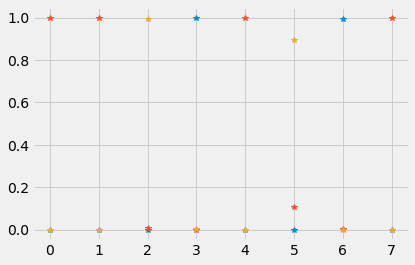

In [12]:
plt.plot(r_ij[:,300:308].T,'*')

### M-Step starts here

In [13]:
"""M Step"""
# Calculate the new mean vector and new covariance matrices
mu = []
cov = []
pi = []
log_likelihood = []

$$\mu_i^t=\sum_{j=1}^n w_j x_j
\textrm{, where }  w_j =\frac {P( y_j=i|x_j,\theta^{t-1})}{\sum_{l=1}^n P( y_l=i|x_l,\theta^{t-1})} = \frac{R_{ij}}{\sum_{l=1}^n R_{il}}
$$

$$\Sigma_i^t=\sum_{j=1}^n w_j(x_j-\mu_i^t)^T(x_j-\mu_i^t)$$

$$\pi_i^t=\frac{1}{n}\sum_{j=1}^n R_{ij}$$

In [14]:
for i in range(K):
    # Updating the mean vectors mu_i:

    m_i = np.sum(r_ij[i,:])
    mu_i = (1/m_i)*np.sum(X*(r_ij[i,:].reshape(n_samples,1)),axis=0) #this will create a d-dim row vector
    mu.append(mu_i)

   # Updating the covariance matrices Sigma_i:

    cov.append(((1/m_i)*np.dot((np.array(r_ij[i,:]).reshape(n_samples,1)*(X-mu_i)).T,(X-mu_i)))+reg_cov)
    
    # Calculate pi_new
    pi.append(1/n_samples*np.sum(r_ij[i,:])) 


In [15]:
mu

[array([2.31677332, 1.7374983 ]),
 array([-8.05863195,  5.15331018]),
 array([-7.65336193, -4.71705356])]

In [16]:
"""Log likelihood"""
log_likelihoods.append(np.log(np.sum([k*multivariate_normal(mu[i],cov[j]).pdf(X) for k,i,j in zip(pi,range(len(mu)),range(len(cov)))])))


In [17]:
print(log_likelihoods)

[2.41998226815529]


In [18]:
mu=np.array(mu)
print(np.array(mu))

[[ 2.31677332  1.7374983 ]
 [-8.05863195  5.15331018]
 [-7.65336193 -4.71705356]]


In [19]:
cov=np.array(cov)
print(cov)

[[[ 2.4984909  -1.53385487]
  [-1.53385487  2.46660971]]

 [[ 2.08619865  1.03314813]
  [ 1.03314813 15.97780923]]

 [[ 4.04102716  2.45711407]
  [ 2.45711407  3.18532761]]]


In [20]:
print(pi)

[0.15753340516660463, 0.6245454813958753, 0.21792111343752008]


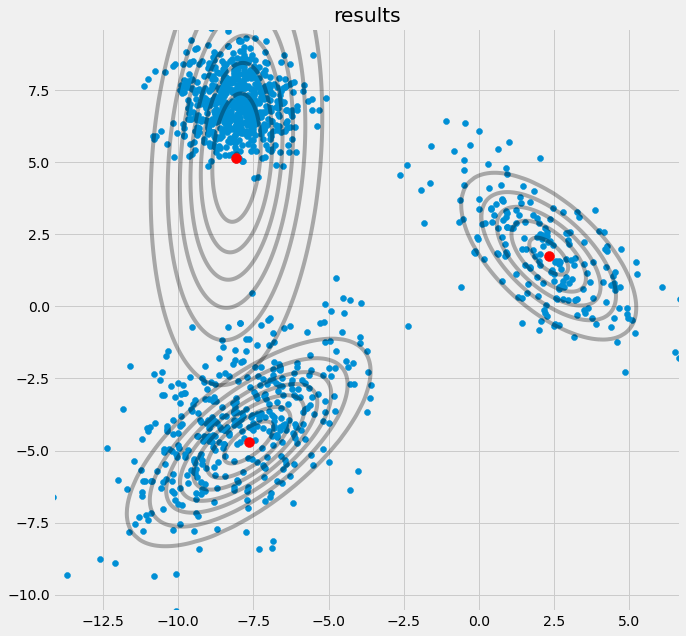

In [21]:
plot_results(X, mu=mu,cov=cov)

In [22]:
print("Now go back to the E Step!")

Now go back to the E Step!


### Putting everything together

In [28]:
class GMM:
    def __init__(self,X,number_of_sources,iterations):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.dim = 2
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        
    
    """Define a function which runs for iterations, iterations"""
    def run(self):
        self.reg_cov = 1e-6*np.identity(len(X[0,:]))
           

        n_samples= len(self.X)
        K= 3

        """ 1. Set the initial mu, covariance and pi values"""
        np.random.seed(0)
        self.mu, self.cov, self.pi = init_params(self.number_of_sources,self.dim)
        
        log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                             # if we have converged
         
        plot_results(X,mu=self.mu,cov=self.cov)
        
        for iter in range(self.iterations):  
            print('iter:', iter)
            """E Step"""

            r_ij = np.zeros([K,n_samples])

            mu = np.array(self.mu)
            cov = np.array(self.cov)
            pi =np.array(self.pi)

            for j in range(n_samples):
                for i in range(K):
                     mn = multivariate_normal(mean=mu[i,:],cov=cov[i,:,:]+reg_cov)
                     r_ij[i,j]=pi[i]*mn.pdf(X[j,:])
                r_ij[:,j]=r_ij[:,j]/np.sum(r_ij[:,j])


            #for m,co,p,r in zip(self.mu,self.cov,self.pi,range(len(r_ic[0]))):
            #    co+=self.reg_cov
            #    mn = multivariate_normal(mean=m,cov=co)
            #    r_ic[:,r] = p*mn.pdf(self.X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.cov+self.reg_cov)],axis=0)
            
            """M Step"""
            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []

            for i in range(K):
                # Updating the mean vectors mu_i:

                m_i = np.sum(r_ij[i,:])
                mu_i = (1/m_i)*np.sum(X*(r_ij[i,:].reshape(n_samples,1)),axis=0) #this will create a d-dim row vector
                self.mu.append(mu_i)

                # Updating the covariance matrices Sigma_i:

                self.cov.append(((1/m_i)*np.dot((np.array(r_ij[i,:]).reshape(n_samples,1)*(X-mu_i)).T,(X-mu_i)))+reg_cov)
                
                # Calculate pi_new
                self.pi.append(1/n_samples*np.sum(r_ij[i,:])) 

            print('mu:', np.array(self.mu))
            print('cov:', np.array(self.cov))
            print('pi:', self.pi)
            
                  
            """Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))
            
            """
            This process of E step followed by a M step is now iterated a number of n times. In the second step for instance,
            we use the calculated pi_new, mu_new and cov_new to calculate the new r_ic which are then used in the second M step
            to calculat the mu_new2 and cov_new2 and so on....
            """
            
            plot_results(X,mu=self.mu,cov=self.cov, title=f'results_{iter+1}')
            
        fig2 = plt.figure(figsize=(10,10))
        ax1 = fig2.add_subplot(111) 
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(0,self.iterations,1),log_likelihoods)
        #plt.show()
    
    """Predict the membership of an unseen, new datapoint"""
    def predict(self,Y):
        # PLot the point onto the fittet gaussians
        fig3 = plt.figure(figsize=(10,10))
        ax2 = fig3.add_subplot(111)
        ax2.scatter(self.X[:,0],self.X[:,1])
        for m,c in zip(self.mu,self.cov):
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax2.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax2.scatter(m[0],m[1],c='grey',zorder=10,s=100)
            ax2.set_title('Final state')
            for y in Y:
                ax2.scatter(y[0],y[1],c='orange',zorder=10,s=100)
        prediction = []        
        for m,c in zip(self.mu,self.cov):  
            #print(c)
            prediction.append(multivariate_normal(mean=m,cov=c).pdf(Y)/np.sum([multivariate_normal(mean=mean,cov=cov).pdf(Y) for mean,cov in zip(self.mu,self.cov)]))
        #plt.show()
        return prediction
         
    
    


[[ 1.  0.]
 [-5.  2.]
 [-2. -2.]]
(3, 2, 2)
[[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]
[0.33333333 0.33333333 0.33333333]


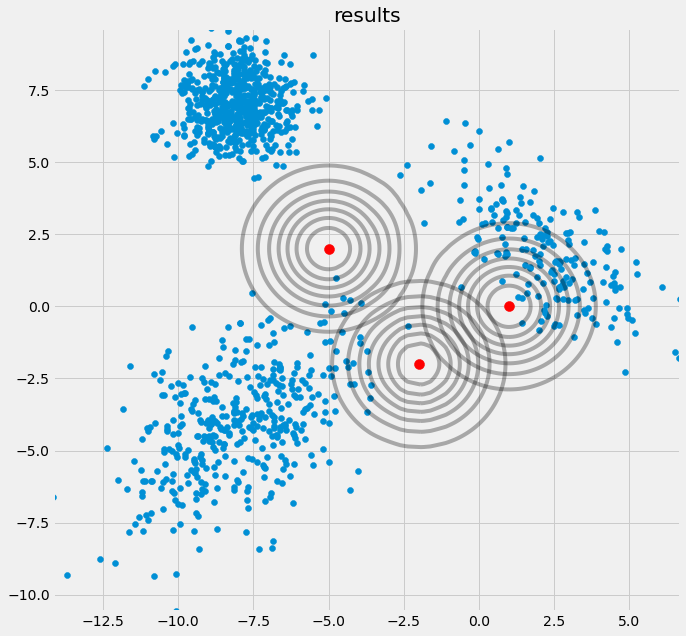

iter: 0
mu: [[ 2.31677332  1.7374983 ]
 [-8.05863195  5.15331018]
 [-7.65336193 -4.71705356]]
cov: [[[ 2.4984909  -1.53385487]
  [-1.53385487  2.46660971]]

 [[ 2.08619865  1.03314813]
  [ 1.03314813 15.97780923]]

 [[ 4.04102716  2.45711407]
  [ 2.45711407  3.18532761]]]
pi: [0.15753340516660463, 0.6245454813958753, 0.21792111343752008]


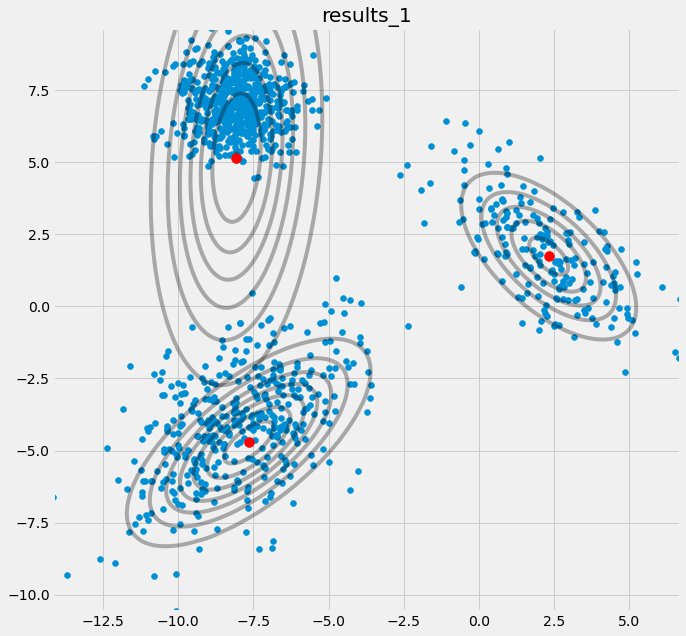

iter: 1
mu: [[ 2.12943453  1.8953263 ]
 [-8.10406314  5.85958497]
 [-7.85846242 -4.48655404]]
cov: [[[ 3.03693266 -1.99544332]
  [-1.99544332  2.85997742]]

 [[ 1.21068426  0.480376  ]
  [ 0.480376   10.89574948]]

 [[ 4.11804735  2.25454897]
  [ 2.25454897  3.14859512]]]
pi: [0.16644203117918419, 0.569157823494439, 0.26440014532637685]


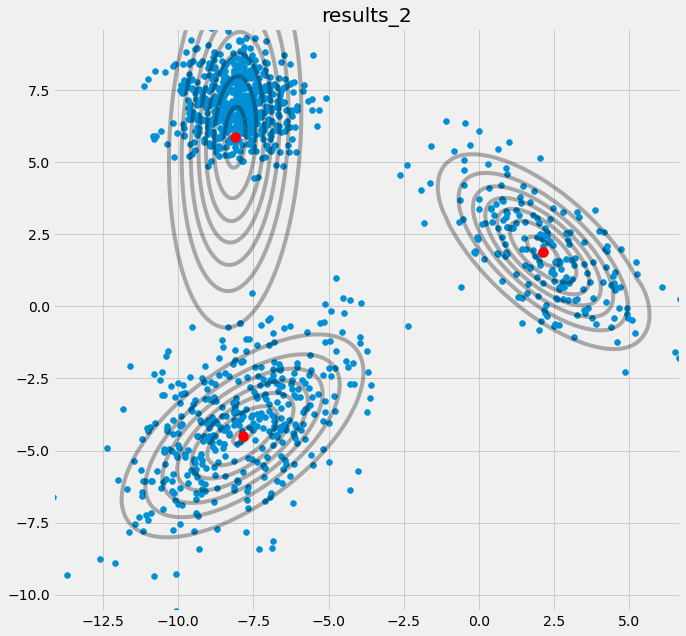

iter: 2
mu: [[ 2.12544008  1.89735036]
 [-8.07758264  6.61057663]
 [-7.941577   -4.27351992]]
cov: [[[ 3.05280583 -2.00383278]
  [-2.00383278  2.86410886]]

 [[ 1.02519247  0.13211303]
  [ 0.13211303  4.37015358]]

 [[ 4.0229206   2.03382765]
  [ 2.03382765  3.36098766]]]
pi: [0.16659183181945197, 0.5245955287594309, 0.30881263942111714]


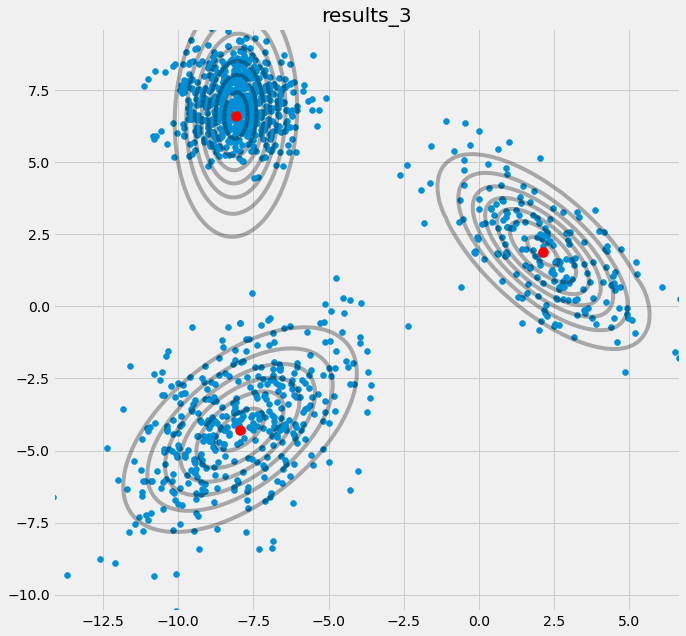

iter: 3
mu: [[ 2.12530826  1.8972529 ]
 [-8.06148483  7.00342551]
 [-7.97565518 -4.09981012]]
cov: [[[ 3.0530327  -2.00355697]
  [-2.00355697  2.8641726 ]]

 [[ 0.97935021 -0.0345778 ]
  [-0.0345778   1.05108193]]

 [[ 3.88576011  1.85893308]
  [ 1.85893308  3.61711969]]]
pi: [0.16660102257382753, 0.5011996969096238, 0.3321992805165486]


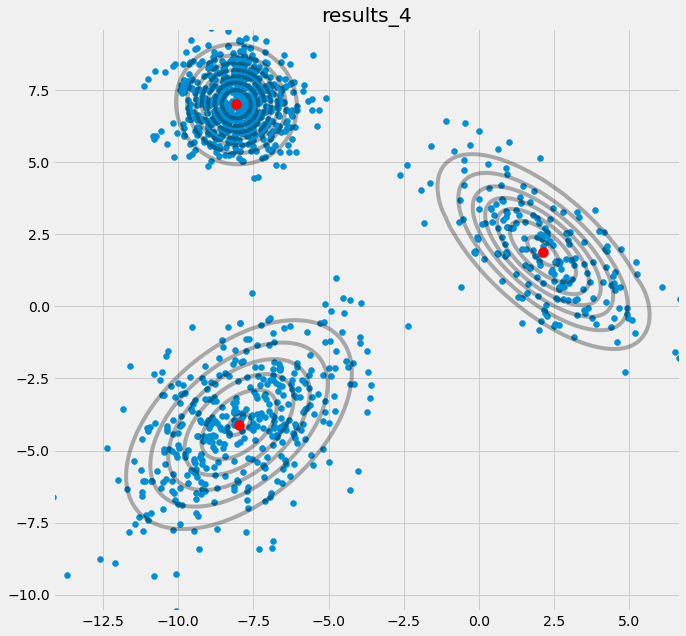

iter: 4
mu: [[ 2.12535937  1.89703008]
 [-8.06190871  7.0207953 ]
 [-7.97550196 -4.08571432]]
cov: [[[ 3.05204194 -2.00244327]
  [-2.00244327  2.86369479]]

 [[ 0.98003295 -0.0321935 ]
  [-0.0321935   0.92722803]]

 [[ 3.87265976  1.85396545]
  [ 1.85396545  3.66101026]]]
pi: [0.16660586755768297, 0.4999949791323724, 0.33339915330994463]


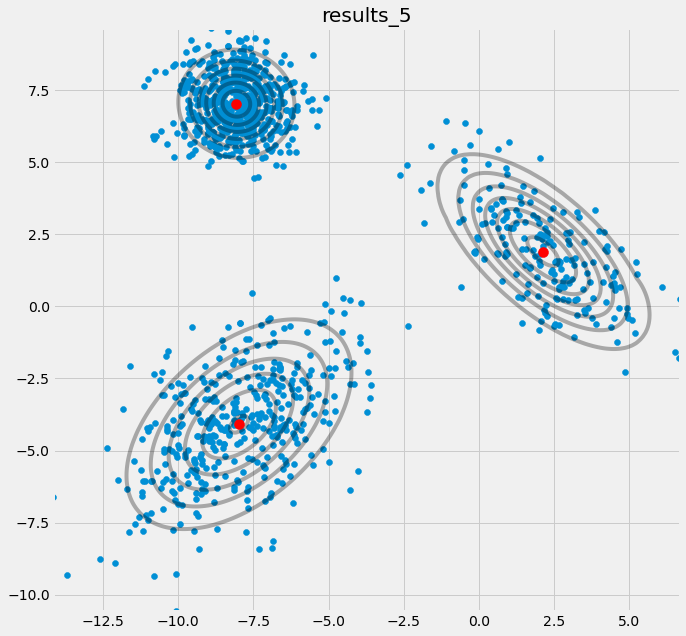

iter: 5
mu: [[ 2.12538383  1.89700811]
 [-8.06190762  7.02079543]
 [-7.97549794 -4.08569834]]
cov: [[[ 3.05190766 -2.00234843]
  [-2.00234843  2.86366151]]

 [[ 0.98003592 -0.03219345]
  [-0.03219345  0.92722699]]

 [[ 3.87265599  1.85403883]
  [ 1.85403883  3.66115897]]]
pi: [0.166605278585155, 0.49999514036267995, 0.33339958105216505]


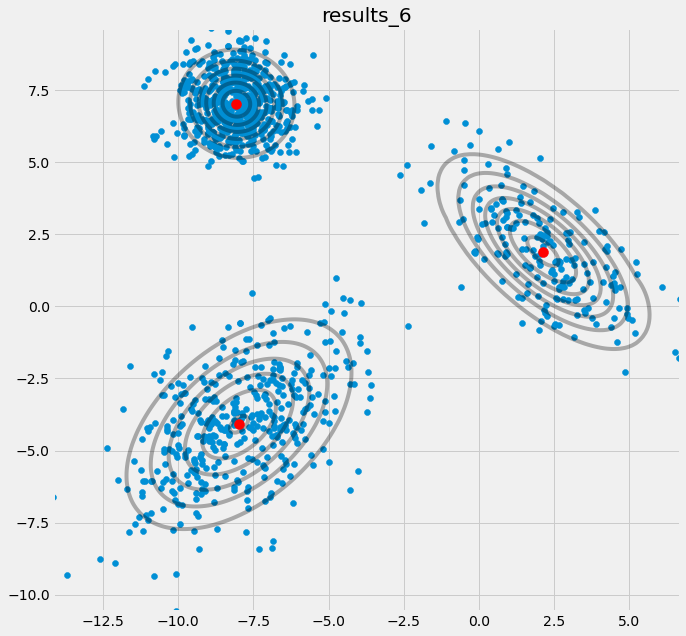

iter: 6
mu: [[ 2.12538414  1.89700799]
 [-8.0619076   7.02079543]
 [-7.97549775 -4.08569814]]
cov: [[[ 3.05190634 -2.00234783]
  [-2.00234783  2.8636612 ]]

 [[ 0.98003595 -0.03219344]
  [-0.03219344  0.92722698]]

 [[ 3.87265712  1.85404006]
  [ 1.85404006  3.66116029]]]
pi: [0.16660526661544445, 0.499995142539661, 0.3333995908448947]


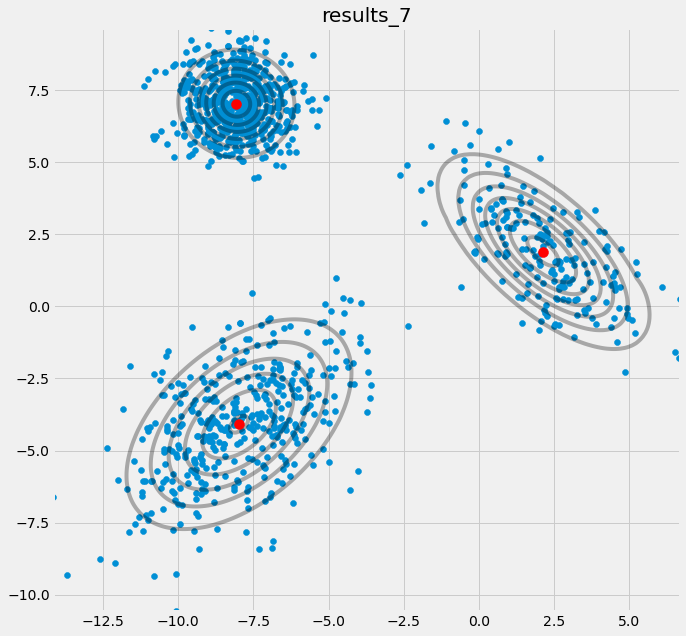

iter: 7
mu: [[ 2.12538415  1.89700799]
 [-8.0619076   7.02079543]
 [-7.97549774 -4.08569813]]
cov: [[[ 3.05190632 -2.00234783]
  [-2.00234783  2.8636612 ]]

 [[ 0.98003595 -0.03219344]
  [-0.03219344  0.92722698]]

 [[ 3.87265717  1.8540401 ]
  [ 1.8540401   3.66116031]]]
pi: [0.16660526629485697, 0.4999951425607695, 0.33339959114437356]


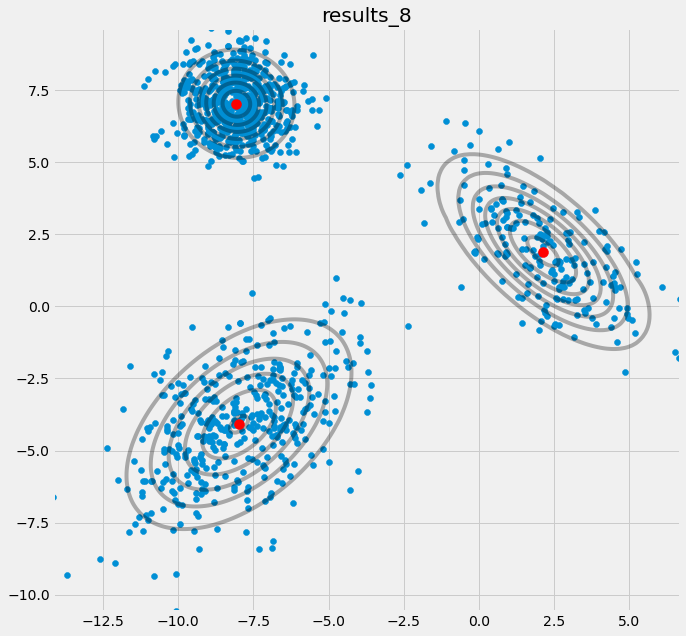

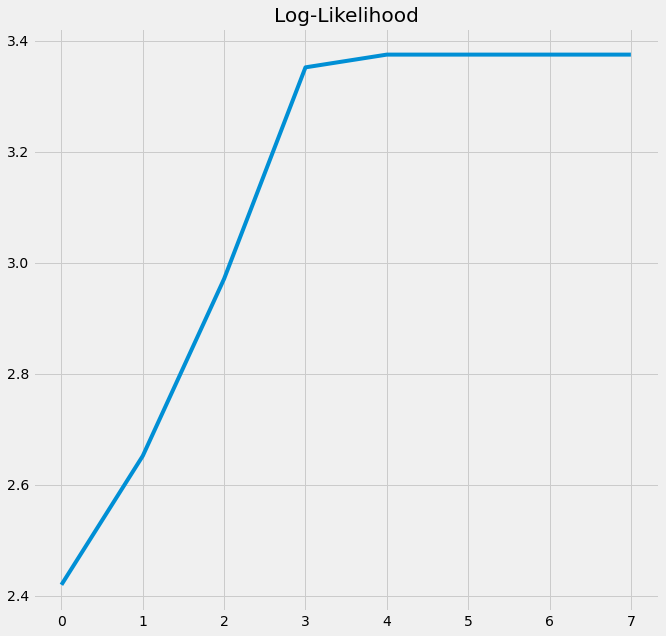

In [29]:
GMM = GMM(X,3,8)     
GMM.run()
#GMM.predict([[0.5,0.5]])

In [30]:
!dir

Initial\ Parameters.png  results_13.png  results_4.png	results_9.png
results_0.png		 results_14.png  results_5.png	results.png
results_10.png		 results_1.png	 results_6.png	sample_data
results_11.png		 results_2.png	 results_7.png
results_12.png		 results_3.png	 results_8.png
